# Cascade of two-neuron modules
*Nhat Le, November 2017*

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

%matplotlib inline

In [2]:
def ecdf(x):
    return np.sort(x), np.arange(len(x)) / len(x)

def save_safe(filename):
    '''Raise an error if file exists'''
    if not os.path.isfile(filename):
        plt.savefig(filename)
    else:
        raise IOError('File exists!')

def thresh_exp(x):
    '''Activation function'''
    return 1 / (1 + np.exp(-x))

def find_u_dot(state, params):
    '''Returns du/dt given the parameters and current state'''
    Wuv = params['Wuv']
    Wut = params['Wut']
    tau = params['tau']
    ext = params['ext']
    theta = params['theta']
    
    u = state['u']
    v = state['v']
    return (-u + thresh_exp(Wut * theta - Wuv * v + ext)) / tau

def find_v_dot(state, params):
    '''Returns dv/dt given the parameters and current state'''
    Wvu = params['Wvu']
    Wvt = params['Wvt']
    tau = params['tau']
    ext = params['ext']
    theta = params['theta']

    
    u = state['u']
    v = state['v']
    return (-v + thresh_exp(Wvt * theta - Wvu * u + ext)) / tau

def update_u_exp(state, params):
    '''Update u based on params'''
    state_new = state.copy()
    state_new['u'] += find_u_dot(state, params) * params['dt']
    return state_new

def update_v_exp(state, params):
    '''Update v based on params'''
    state_new = state.copy()
    state_new['v'] += find_v_dot(state, params) * params['dt']
    return state_new

def simulate_u_v_exp(state_init, params, niter):
    '''Simulate for niter iterations'''
    curr_state = state_init.copy()
    u_lst = [state_init['u']]
    v_lst = [state_init['v']]

    for i in range(niter):
        order = np.random.randint(0, 2)
        if order:
            curr_state = update_u_exp(curr_state, params)    
            curr_state = update_v_exp(curr_state, params)
        else:
            curr_state = update_v_exp(curr_state, params)    
            curr_state = update_u_exp(curr_state, params)
        v_lst.append(curr_state['v'])
        u_lst.append(curr_state['u'])
    return u_lst, v_lst

def find_u_dot_multi(state, params):
    '''Returns du/dt given the parameters and current state'''
    u = state['u']
    v = state['v']
    Wuv = params['Wuv']
    Wut = params['Wut']
    tau = params['tau']
    ext = params['ext']
    theta = params['theta']
    sigma = params['sigma']
        
    noise = np.random.normal(loc=0, scale=sigma, size=len(u))
    return (-u + thresh_exp(Wut * theta - Wuv * v + noise + ext)) / tau

def find_v_dot_multi(state, params):
    '''Returns dv/dt given the parameters and current state'''
    u = state['u']
    v = state['v']
    Wvu = params['Wvu']
    Wvt = params['Wvt']
    tau = params['tau']
    ext = params['ext']
    theta = params['theta']
    sigma = params['sigma']
        
    noise = np.random.normal(loc=0, scale=sigma, size=len(v))
    return (-v + thresh_exp(Wvt * theta - Wvu * u + noise + ext)) / tau

def update_u_exp_multi(state, params):
    '''Update u based on params'''
    state_new = state.copy()
    state_new['u']= state_new['u'] + find_u_dot_multi(state, params) * params['dt']
    return state_new

def update_v_exp_multi(state, params):
    '''Update v based on params'''
    state_new = state.copy()
    state_new['v'] = state_new['v'] + find_v_dot_multi(state, params) * params['dt']
    return state_new

def simulate_u_v_exp_multi(state_init, params, niter):
    '''Simulate for niter iterations'''
    curr_state = state_init.copy()
    u_lst = [state_init['u']]
    v_lst = [state_init['v']]

    for i in range(niter):
        order = np.random.randint(0, 2) # Choose to update u or v first
        if order:
            curr_state = update_u_exp_multi(curr_state, params)
            curr_state = update_v_exp_multi(curr_state, params) 
        else:
            curr_state = update_v_exp_multi(curr_state, params)
            curr_state = update_u_exp_multi(curr_state, params) 
        u_lst.append(curr_state['u'])
        v_lst.append(curr_state['v'])
        
    u_arr = np.vstack(u_lst)
    v_arr = np.vstack(v_lst)
    return u_arr, v_arr

def ecdf(data):
    return np.sort(data), np.arange(len(data)) / len(data)

def get_mean_and_sd_lines(state, params, nstep):
    '''Simulate for n steps and return two arrays, one for mean
    and one for SD across all trials'''
    ulst, vlst = simulate_u_v_exp_multi(state, params, nstep)
    return np.mean(ulst, axis=1), np.mean(vlst, axis=1), \
            np.std(ulst, axis=1), np.std(vlst, axis=1)

In [3]:
def get_times_lst(state, params, nsteps, threshold):
    '''Given a starting state and parameters,
    return the time(s) that the threshold is reached'''
    ulst, vlst = simulate_u_v_exp_multi(state, params, nsteps)
    decision_v = ulst - vlst
    
    return get_times_lst_from_decision_v(decision_v, threshold)

def get_times_lst_from_decision_v(decv_lst, threshold):
    times_lst = []
    
    # Find time to act
    for k in range(ntrials):
        # Check if the bound is reached (sometimes it's not!)
        if np.max(decv_lst[:,k]) > threshold:
            times_lst.append(np.nonzero(decv_lst[:, k] > threshold)[0][0])
        else:
            times_lst.append(np.inf)
            #print('Bound not reached')
    
    return np.array(times_lst)

In [4]:
def simulate_module(ntrials, nsteps, nsteps_goal, ext_lst, params, 
                    K, prev_final=np.array([]), ext_updating=False):
    '''Simulate a single module
    Returns the list of final positions'''
    ext_lst_new = np.array(ext_lst)
    state_dict = {'u': np.array([0.7] * ntrials), 'v': np.array([0.2] * ntrials)}
    if ext_updating:
        assert(prev_final.shape != (0,))
        ext_lst_new += K * (prev_final - np.mean(prev_final))
    params['ext'] = ext_lst_new
    
    ulst_noise, vlst_noise = simulate_u_v_exp_multi(state_dict, params, nsteps)
    decision_v = ulst_noise - vlst_noise
    
    threshold = np.nanmean(decision_v[nsteps_goal]) # TODO: check if this is a valid threshold
    times_lst = get_times_lst_from_decision_v(decision_v, threshold)
    
    return ext_lst_new, (ulst_noise - vlst_noise)[nsteps_goal, :], np.array(times_lst)

## The no-noise condition

In [5]:
ntrials = 20
nsteps = 3000
thetas = np.linspace(0.6, 0.8, ntrials)
state_dict = {'u': np.array([0.7] * ntrials), 'v': np.array([0.2] * ntrials)}
param_dict_module = {'Wut': 6, 'Wvt': 6, 'Wuv': 6, 'Wvu': 6,
              'theta': thetas, 'tau': 100, 'dt': 1, 'ext': 0, 'sigma': 0}
threshold = 0.1

ulst_noise, vlst_noise = simulate_u_v_exp_multi(state_dict, param_dict_module, nsteps)
decision_v = ulst_noise - vlst_noise
    
threshold = 0.65
#threshold = np.nanmean(decision_v[nsteps_goal]) # TODO: check if this is a valid threshold
times_lst = get_times_lst_from_decision_v(decision_v, threshold)


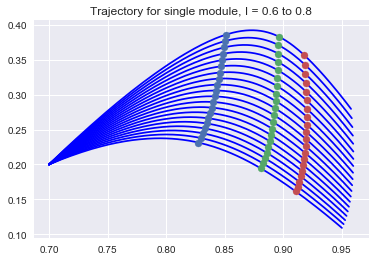

In [6]:
plt.plot(ulst_noise, vlst_noise, 'b', zorder=1)
plt.scatter(ulst_noise[100], vlst_noise[100], zorder=2)
plt.scatter(ulst_noise[200], vlst_noise[200], zorder=3)
plt.scatter(ulst_noise[300], vlst_noise[300], zorder=4)
plt.title('Trajectory for single module, I = 0.6 to 0.8')

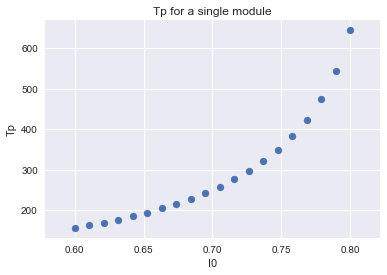

In [7]:
plt.scatter(thetas, times_lst)
plt.xlabel('I0')
plt.ylabel('Tp')
plt.title('Tp for a single module')

# Can we really model this??

In [8]:
# Two modules
ntrials = 20
threshold = 0.65
nsteps = 3000
thetas = np.linspace(0.5, 0.8, ntrials)

state_dict = {'u': np.array([0.7] * ntrials), 'v': np.array([0.2] * ntrials)}
param_dict_module = {'Wut': 6, 'Wvt': 6, 'Wuv': 6, 'Wvu': 6,
              'theta': thetas, 'tau': 100, 'dt': 1, 'ext': 0, 'sigma': 0}

ulst_noise1, vlst_noise1 = simulate_u_v_exp_multi(state_dict, param_dict_module, nsteps)
ulst_noise2, vlst_noise2 = simulate_u_v_exp_multi(state_dict, param_dict_module, nsteps)

decision_v1 = ulst_noise1 - vlst_noise1
decision_v2 = ulst_noise2 - vlst_noise2
    
times_lst1 = get_times_lst_from_decision_v(decision_v1, threshold)
times_lst2 = get_times_lst_from_decision_v(decision_v2, threshold)





As expected, having two modules simply doubles the production time of a single module

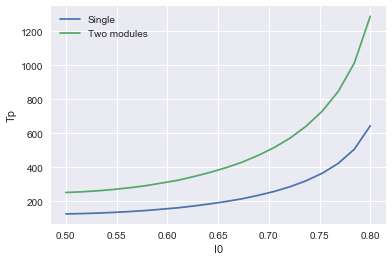

In [9]:
plt.plot(thetas, times_lst1, label='Single')
plt.plot(thetas, times_lst1 + times_lst2, label='Two modules')
plt.legend()
plt.xlabel('I0')
plt.ylabel('Tp')


## Effect of $\sigma_\sigma$

We first simulate a single module. We adjust $\theta$ to make the mean time to threshold = 400

In [7]:
# One module
ntrials = 1000
nsteps = 3000
thetas = 0.752 # This makes mean = 400
state_dict = {'u': np.array([0.7] * ntrials), 'v': np.array([0.2] * ntrials)}
param_dict_module = {'Wut': 6, 'Wvt': 6, 'Wuv': 6, 'Wvu': 6,
              'theta': thetas, 'tau': 100, 'dt': 1, 'ext': 0, 'sigma': 0.3}

ulst_sigma_single, vlst_sigma_single = simulate_u_v_exp_multi(state_dict, param_dict_module, nsteps)

decision_sigma_single = ulst_sigma_single - vlst_sigma_single
    
times_lst_sigma_single = get_times_lst_from_decision_v(decision_sigma_single, threshold)

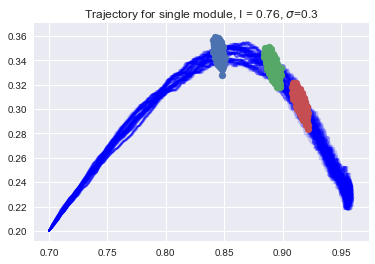

In [8]:
plt.plot(ulst_sigma_single[:,::10], vlst_sigma_single[:,::100], 'b', alpha=0.2);
plt.scatter(ulst_sigma_single[100], vlst_sigma_single[100], zorder=3)
plt.scatter(ulst_sigma_single[200], vlst_sigma_single[200], zorder=3)
plt.scatter(ulst_sigma_single[300], vlst_sigma_single[300], zorder=4)
plt.title(r'Trajectory for single module, I = 0.76, $\sigma$=0.3')

398.366 20.6234343406


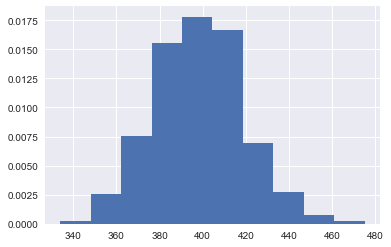

In [9]:
#Confirming that the mean is indeed 400
plt.hist(times_lst_sigma_single, normed=True)
print(np.mean(times_lst_sigma_single), np.std(times_lst_sigma_single))

For two modules, we can again adjust $\theta$ to make sure the mean total time is 400

In [10]:
# Two modules
ntrials = 1000
nsteps = 3000
theta = 0.658 # This makes mean = 400
state_dict = {'u': np.array([0.7] * ntrials), 'v': np.array([0.2] * ntrials)}
param_dict_module = {'Wut': 6, 'Wvt': 6, 'Wuv': 6, 'Wvu': 6,
              'theta': theta, 'tau': 100, 'dt': 1, 'ext': 0, 'sigma': 0.1}

ulst_noise_sigma1, vlst_noise_sigma1 = simulate_u_v_exp_multi(state_dict, param_dict_module, nsteps)
ulst_noise_sigma2, vlst_noise_sigma2 = simulate_u_v_exp_multi(state_dict, param_dict_module, nsteps)

decision_sigma1 = ulst_noise_sigma1 - vlst_noise_sigma1
decision_sigma2 = ulst_noise_sigma2 - vlst_noise_sigma2
    
times_lst_sigma1 = get_times_lst_from_decision_v(decision_sigma1, threshold)
times_lst_sigma2 = get_times_lst_from_decision_v(decision_sigma2, threshold)
times_lst_sigma = times_lst_sigma1 + times_lst_sigma2
print(np.mean(times_lst_sigma))

400.916


And we compare the distribution of times! The two modules has a lower variance (3.9 compared to 20.4). But why? I don't have a good intuition here.

398.366 20.6234343406
400.916 3.81509423213


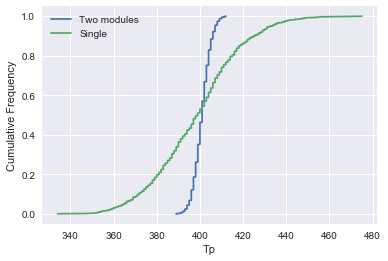

In [11]:
x1, y1 = ecdf(times_lst_sigma)
x2, y2 = ecdf(times_lst_sigma_single)
plt.plot(x1, y1, label='Two modules')
plt.plot(x2, y2, label='Single')
plt.xlabel('Tp')
plt.ylabel('Cumulative Frequency')
plt.legend()


print(np.mean(times_lst_sigma_single), np.std(times_lst_sigma_single))
print(np.mean(times_lst_sigma), np.std(times_lst_sigma))

## Update model

Now here's the part where we make use of the update. We assume the threshold information is known (kept at 0.65), and subtract the final state of the system from the threshold.

In [ ]:
def simulate_two_modules(ntrials, nsteps, theta, K, threshold)

In [16]:
# Two modules
ntrials = 1000
nsteps = 3000
theta = 0.65 # This makes mean = 400
threshold = 0.65 

state_dict = {'u': np.array([0.7] * ntrials), 'v': np.array([0.2] * ntrials)}

varlst = []
meanlst = []
Klst = np.linspace(1, 3, 20)
meanlst = np.zeros((10, 20))
varlst = np.zeros((10, 20))

for idtheta, theta in enumerate(np.linspace(0.6, 0.7, 10)):
    print('theta = ', theta)
    for idK, K in enumerate(Klst):
        param_dict_module = {'Wut': 6, 'Wvt': 6, 'Wuv': 6, 'Wvu': 6,
                  'theta': theta, 'tau': 100, 'dt': 1, 'ext': 0, 'sigma': 0.3}
        # Module 1
        print('    K = ', K)
        param_dict_module['theta'] = theta # Initial theta
        state_dict = {'u': np.array([0.7] * ntrials), 'v': np.array([0.2] * ntrials)}
        ulst_noise_sigma1, vlst_noise_sigma1 = simulate_u_v_exp_multi(state_dict, param_dict_module, nsteps)

        decision_sigma1 = ulst_noise_sigma1 - vlst_noise_sigma1

        # Module 2 with correction
        theta2 = theta + K * (decision_sigma1[199] - threshold)

        param_dict_module['theta'] = theta2
        ulst_noise_sigma2, vlst_noise_sigma2 = simulate_u_v_exp_multi(state_dict, param_dict_module, nsteps)

        decision_sigma2 = ulst_noise_sigma2 - vlst_noise_sigma2
        times_lst_sigma1 = get_times_lst_from_decision_v(decision_sigma1, threshold)
        times_lst_sigma2 = get_times_lst_from_decision_v(decision_sigma2, threshold)
        times_lst_sigma = times_lst_sigma1 + times_lst_sigma2
        #varlst.append(np.std(times_lst_sigma))
        #meanlst.append(np.mean(times_lst_sigma))
        meanlst[idtheta, idK] = np.mean(times_lst_sigma)
        varlst[idtheta, idK] = np.std(times_lst_sigma)

theta =  0.6
    K =  1.0
    K =  1.10526315789
    K =  1.21052631579
    K =  1.31578947368
    K =  1.42105263158
    K =  1.52631578947
    K =  1.63157894737
    K =  1.73684210526
    K =  1.84210526316
    K =  1.94736842105
    K =  2.05263157895
    K =  2.15789473684
    K =  2.26315789474
    K =  2.36842105263
    K =  2.47368421053
    K =  2.57894736842
    K =  2.68421052632
    K =  2.78947368421
    K =  2.89473684211
    K =  3.0
theta =  0.611111111111
    K =  1.0
    K =  1.10526315789
    K =  1.21052631579
    K =  1.31578947368
    K =  1.42105263158
    K =  1.52631578947
    K =  1.63157894737
    K =  1.73684210526
    K =  1.84210526316
    K =  1.94736842105
    K =  2.05263157895
    K =  2.15789473684
    K =  2.26315789474
    K =  2.36842105263
    K =  2.47368421053
    K =  2.57894736842
    K =  2.68421052632
    K =  2.78947368421
    K =  2.89473684211
    K =  3.0
theta =  0.622222222222
    K =  1.0
    K =  1.10526315789
    K =  1.21052631579


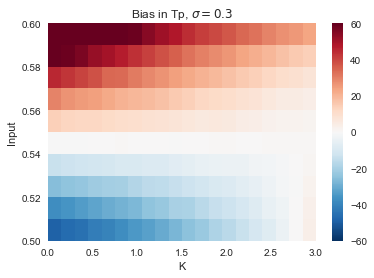

In [25]:
plt.imshow(np.flipud(meanlst - 400), cmap='RdBu_r', aspect='auto', \
           vmin=-60, vmax=60, extent=[0, 3, 0.5, 0.6])
plt.grid(False)
plt.colorbar()
plt.xlabel('K')
plt.ylabel('Input')
plt.title(r'Bias in Tp, $\sigma=0.3$')
#save_safe('bias_two_modules_sigma_0_3.pdf')

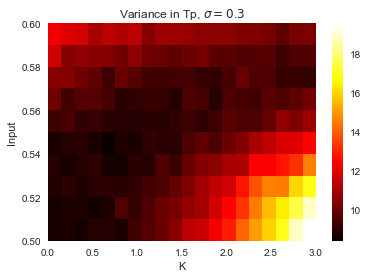

In [23]:
plt.imshow(np.flipud(varlst), cmap='hot', aspect='auto', extent=[0, 3, 0.5, 0.6])
plt.colorbar()
plt.grid(False)
plt.xlabel('K')
plt.ylabel('Input')
plt.title(r'Variance in Tp, $\sigma=0.3$')
#save_safe('variance_two_modules_sigma_0_3.pdf')

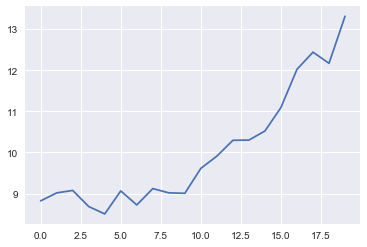

In [39]:
plt.plot(((meanlst - 400)**2 +  varlst)[4].T);

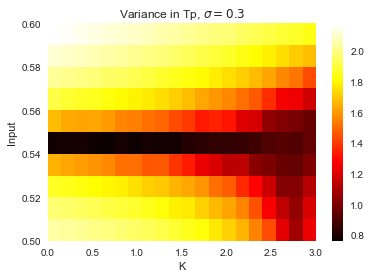

In [29]:
plt.imshow(np.log(np.log(np.flipud((meanlst - 400)**2 +  varlst))), cmap='hot', aspect='auto', extent=[0, 3, 0.5, 0.6])
plt.colorbar()
plt.grid(False)
plt.xlabel('K')
plt.ylabel('Input')
plt.title(r'Variance in Tp, $\sigma=0.3$')
#save_safe('bias_variance_two_modules_sigma_0_3.pdf')

An optimal value of $K = 1.5$ is found to minimize the variance in $T_p$. There seems to be a bias in the mean $T_p$ as well. The point of minimum variance also happens to have zero bias. Is this a coincidence?

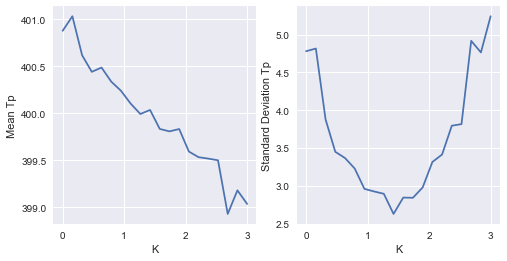

In [21]:
plt.figure(figsize=(8, 4))
plt.subplot('121')
plt.plot(Klst, meanlst)
plt.xlabel('K')
plt.ylabel('Mean Tp')

plt.subplot('122')
plt.plot(Klst, np.array(varlst) + (np.array(meanlst) - 400)**2)
plt.xlabel('K')
plt.ylabel('Standard Deviation Tp')

## Effect of $\sigma_\sigma$

In the previous section we worked with a single value $\sigma_\sigma=0.3$. Here we would like to get a sense of how the optimal value of $K$ changes as a function of $\sigma_\sigma$.

In [146]:
# Two modules
ntrials = 1000
nsteps = 3000
theta = 0.644 # This makes mean = 400
threshold = 0.65

This is the theta that will give an expected time of 400 for values of $\sigma_\sigma$ = 0, 0.1, 0.2, ..., 0.5

In [147]:
theta_lst = np.array([[0    , 0.1  , 0.2  , 0.3  , 0.4  , 0.5  ],
                      [0.659, 0.658, 0.653, 0.644, 0.632, 0.613]])

In [148]:
Klst = np.linspace(0, 3, 10)
varlst = np.zeros((6, 10))
meanlst = np.zeros((6, 10))

for i in range(theta_lst.shape[1]):
    sigma_sigma = theta_lst[0, i]
    theta = theta_lst[1, i]
    state_dict = {'u': np.array([0.7] * ntrials), 'v': np.array([0.2] * ntrials)}
    param_dict_module = {'Wut': 6, 'Wvt': 6, 'Wuv': 6, 'Wvu': 6,
                  'theta': theta, 'tau': 100, 'dt': 1, 'ext': 0, 'sigma': sigma_sigma}
    for j, K in enumerate(Klst):
        print('Working, i = ', i, 'K = ', K)
        # Module 1
        state_dict = {'u': np.array([0.7] * ntrials), 'v': np.array([0.2] * ntrials)}
        param_dict_module['theta'] = theta # Initial theta
        ulst_noise_sigma1, vlst_noise_sigma1 = simulate_u_v_exp_multi(state_dict, param_dict_module, nsteps)

        decision_sigma1 = ulst_noise_sigma1 - vlst_noise_sigma1

        # Module 2 with correction
        theta2 = theta + K * (decision_sigma1[199] - threshold)

        param_dict_module['theta'] = theta2
        ulst_noise_sigma2, vlst_noise_sigma2 = simulate_u_v_exp_multi(state_dict, param_dict_module, nsteps)

        decision_sigma2 = ulst_noise_sigma2 - vlst_noise_sigma2
        times_lst_sigma1 = get_times_lst_from_decision_v(decision_sigma1, threshold)
        times_lst_sigma2 = get_times_lst_from_decision_v(decision_sigma2, threshold)
        times_lst_sigma = times_lst_sigma1 + times_lst_sigma2
        varlst[i][j] = np.std(times_lst_sigma)
        meanlst[i][j] = np.mean(times_lst_sigma)

Working, i =  0 K =  0.0
Working, i =  0 K =  0.333333333333
Working, i =  0 K =  0.666666666667
Working, i =  0 K =  1.0
Working, i =  0 K =  1.33333333333
Working, i =  0 K =  1.66666666667
Working, i =  0 K =  2.0
Working, i =  0 K =  2.33333333333
Working, i =  0 K =  2.66666666667
Working, i =  0 K =  3.0
Working, i =  1 K =  0.0
Working, i =  1 K =  0.333333333333
Working, i =  1 K =  0.666666666667
Working, i =  1 K =  1.0
Working, i =  1 K =  1.33333333333
Working, i =  1 K =  1.66666666667
Working, i =  1 K =  2.0
Working, i =  1 K =  2.33333333333
Working, i =  1 K =  2.66666666667
Working, i =  1 K =  3.0
Working, i =  2 K =  0.0
Working, i =  2 K =  0.333333333333
Working, i =  2 K =  0.666666666667
Working, i =  2 K =  1.0
Working, i =  2 K =  1.33333333333
Working, i =  2 K =  1.66666666667
Working, i =  2 K =  2.0
Working, i =  2 K =  2.33333333333
Working, i =  2 K =  2.66666666667
Working, i =  2 K =  3.0
Working, i =  3 K =  0.0
Working, i =  3 K =  0.333333333333
Wor

Interestingly, the bias is relatively constant while the minimum point of the variance occurs consistently at $K \approx 1.5$

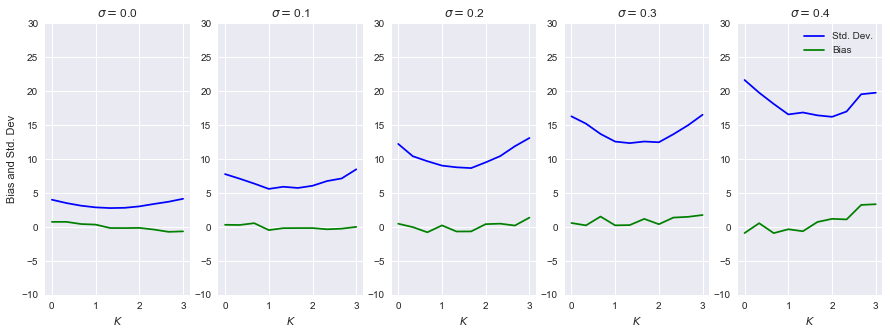

In [156]:
fig, ax = plt.subplots(1, 5, figsize=(15, 5))
for i in range(1, 6):
    sq_bias = (meanlst[i]-400)**2
    biasid = np.argmin(sq_bias)
    varid = np.argmin(varlst[i])
    ax[i-1].plot(Klst, varlst[i], color='b', label='Std. Dev.')
    ax[i-1].plot(Klst, meanlst[i] - 400, color='g', label='Bias')
    ax[i-1].set_ylim((-10, 30))
    ax[i-1].set_xlabel(r'$K$')
    ax[i-1].set_title(r'$\sigma=$' + str(theta_lst[0, i-1]))
    #ax[i-1].axvline(x=Klst[biasid], linestyle='--', color='g')
    #ax[i-1].axvline(x=Klst[varid], linestyle='--', color='b')

ax[0].set_ylabel('Bias and Std. Dev')
ax[4].legend();
save_safe('bias_variance_sigma_sigma.pdf')


## Effect of $\sigma_\mu$

We now turn to the effect of $\sigma_\mu$ and try to find values of $K$ that help the system correct its $T_p$. My previous result has shown that the bias of $T_p$ can be kept close to 0 at certain values of $\theta$, while the variance can be controlled by $K$. Thus, we can reuse the $\theta$ table obtained previously to set the right $I$ for the system to achieve time = 400.

In [150]:
# Two modules
ntrials = 1000
nsteps = 3000
theta = 0.644 # This makes mean = 400
threshold = 0.65 

state_dict = {'u': np.array([0.7] * ntrials), 'v': np.array([0.2] * ntrials)}
mu_ext = np.random.normal(0, 0.3, ntrials)
param_dict_module = {'Wut': 6, 'Wvt': 6, 'Wuv': 6, 'Wvu': 6,
              'theta': theta, 'tau': 100, 'dt': 1, 'ext': mu_ext, 'sigma': 0}

ulst_noise_sigma1, vlst_noise_sigma1 = simulate_u_v_exp_multi(state_dict, param_dict_module, nsteps)
ulst_noise_sigma2, vlst_noise_sigma2 = simulate_u_v_exp_multi(state_dict, param_dict_module, nsteps)

decision_sigma1 = ulst_noise_sigma1 - vlst_noise_sigma1
decision_sigma2 = ulst_noise_sigma2 - vlst_noise_sigma2
    
times_lst_sigma1 = get_times_lst_from_decision_v(decision_sigma1, threshold)
times_lst_sigma2 = get_times_lst_from_decision_v(decision_sigma2, threshold)
times_lst_sigma = times_lst_sigma1 + times_lst_sigma2
print(np.mean(times_lst_sigma))

inf


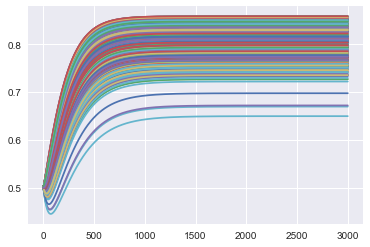

In [151]:
plt.plot(decision_sigma1);

Again we see the familiar shape of the $\sigma_\mu$ trials with a more 'ordered' time steps. At large values of $\sigma_\mu$, deviations can be detrimental as the system never crosses threshold.

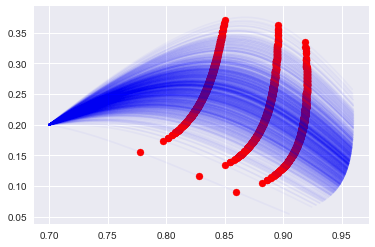

In [143]:
plt.plot(ulst_noise_sigma1, vlst_noise_sigma1, 'b', alpha=0.03);
plt.scatter(ulst_noise_sigma1[100], vlst_noise_sigma1[100], color='r');
plt.scatter(ulst_noise_sigma1[200], vlst_noise_sigma1[200], color='r');
plt.scatter(ulst_noise_sigma1[300], vlst_noise_sigma1[300], color='r');

Now we try to introduce updating with $K$ and see what happens

In [186]:
# Two modules
ntrials = 1000
nsteps = 3000
theta = 0.65 # This makes mean = 400
threshold = 0.65 

state_dict = {'u': np.array([0.7] * ntrials), 'v': np.array([0.2] * ntrials)}

varlst = []
meanlst = []
Klst = np.linspace(0, 4, 20)
meanlst = np.zeros((10, 20))
varlst = np.zeros((10, 20))
mu_ext = np.random.normal(0, 0.1, ntrials)

for idtheta, theta in enumerate(np.linspace(0.5, 0.7, 10)):
    print('theta = ', theta)
    for idK, K in enumerate(Klst):
        param_dict_module = {'Wut': 6, 'Wvt': 6, 'Wuv': 6, 'Wvu': 6,
                  'theta': theta, 'tau': 100, 'dt': 1, 'ext': mu_ext, 'sigma': 0}
        # Module 1
        print('    K = ', K)
        param_dict_module['theta'] = theta # Initial theta
        state_dict = {'u': np.array([0.7] * ntrials), 'v': np.array([0.2] * ntrials)}
        ulst_noise_sigma1, vlst_noise_sigma1 = simulate_u_v_exp_multi(state_dict, param_dict_module, nsteps)

        decision_sigma1 = ulst_noise_sigma1 - vlst_noise_sigma1

        # Module 2 with correction
        theta2 = theta + K * (decision_sigma1[199] - threshold)

        param_dict_module['theta'] = theta2
        ulst_noise_sigma2, vlst_noise_sigma2 = simulate_u_v_exp_multi(state_dict, param_dict_module, nsteps)

        decision_sigma2 = ulst_noise_sigma2 - vlst_noise_sigma2
        times_lst_sigma1 = get_times_lst_from_decision_v(decision_sigma1, threshold)
        times_lst_sigma2 = get_times_lst_from_decision_v(decision_sigma2, threshold)
        times_lst_sigma = times_lst_sigma1 + times_lst_sigma2
        #varlst.append(np.std(times_lst_sigma))
        #meanlst.append(np.mean(times_lst_sigma))
        meanlst[idtheta, idK] = np.mean(times_lst_sigma)
        varlst[idtheta, idK] = np.std(times_lst_sigma)

theta =  0.5
    K =  0.0
    K =  0.210526315789
    K =  0.421052631579
    K =  0.631578947368
    K =  0.842105263158
    K =  1.05263157895
    K =  1.26315789474
    K =  1.47368421053
    K =  1.68421052632
    K =  1.89473684211
    K =  2.10526315789
    K =  2.31578947368
    K =  2.52631578947
    K =  2.73684210526
    K =  2.94736842105
    K =  3.15789473684
    K =  3.36842105263
    K =  3.57894736842
    K =  3.78947368421
    K =  4.0
theta =  0.522222222222
    K =  0.0
    K =  0.210526315789
    K =  0.421052631579
    K =  0.631578947368
    K =  0.842105263158
    K =  1.05263157895
    K =  1.26315789474
    K =  1.47368421053
    K =  1.68421052632
    K =  1.89473684211
    K =  2.10526315789
    K =  2.31578947368
    K =  2.52631578947
    K =  2.73684210526
    K =  2.94736842105
    K =  3.15789473684
    K =  3.36842105263
    K =  3.57894736842
    K =  3.78947368421
    K =  4.0
theta =  0.544444444444
    K =  0.0
    K =  0.210526315789
    K =  0.421

In [177]:
np.linspace(0.5, 0.7, 10)[7]

0.65555555555555545

In [ ]:
theta

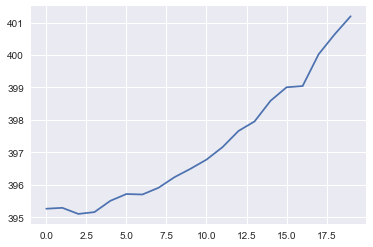

In [176]:
plt.plot(meanlst[7,:]);

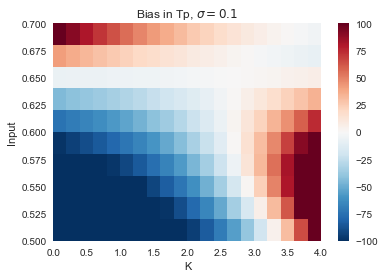

In [196]:
plt.imshow(np.flipud(meanlst - 400), cmap='RdBu_r', aspect='auto', \
           vmin = -100, vmax=100, extent=[0, 4, 0.5, 0.7])
plt.grid(False)
plt.colorbar()
plt.xlabel('K')
plt.ylabel('Input')
plt.title(r'Bias in Tp, $\sigma=0.1$')
save_safe('bias_two_modules_sigma_mu_0_1.pdf')

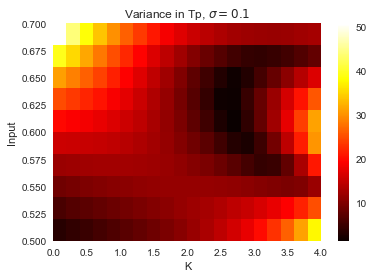

In [197]:
plt.imshow(np.flipud(varlst), cmap='hot', aspect='auto', \
           extent=[0, 4, 0.5, 0.7])
plt.grid(False)
plt.colorbar()
plt.xlabel('K')
plt.ylabel('Input')
plt.title(r'Variance in Tp, $\sigma=0.1$')
save_safe('variance_two_modules_sigma_mu_0_1.pdf')

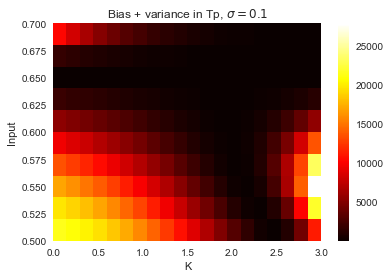

In [202]:
plt.imshow(np.flipud(varlst + (meanlst - 400)**2), cmap='hot', aspect='auto', \
           extent=[0, 3, 0.5, 0.7])
plt.grid(False)
plt.colorbar()
plt.xlabel('K')
plt.ylabel('Input')
plt.title(r'Bias + variance in Tp, $\sigma=0.1$')
save_safe('bias_variance_two_modules_sigma_mu_0_1.pdf')

In [178]:
# Two modules
ntrials = 1000
nsteps = 3000
theta = 0.656 # This makes mean = 400

mu_ext = np.random.normal(0, 0.1, ntrials)
state_dict = {'u': np.array([0.7] * ntrials), 'v': np.array([0.2] * ntrials)}
param_dict_module = {'Wut': 6, 'Wvt': 6, 'Wuv': 6, 'Wvu': 6,
              'theta': theta, 'tau': 100, 'dt': 1, 'ext': mu_ext, 'sigma': 0}
varlst = []
meanlst = []
Klst = np.linspace(0, 4, 15)

for K in Klst:
    # Module 1
    print(K)
    param_dict_module['theta'] = theta # Initial theta
    state_dict = {'u': np.array([0.7] * ntrials), 'v': np.array([0.2] * ntrials)}
    ulst_noise_sigma1, vlst_noise_sigma1 = simulate_u_v_exp_multi(state_dict, param_dict_module, nsteps)
    
    decision_sigma1 = ulst_noise_sigma1 - vlst_noise_sigma1

    # Module 2 with correction
    theta2 = theta + K * (decision_sigma1[199] - threshold)
    
    param_dict_module['theta'] = theta2
    ulst_noise_sigma2, vlst_noise_sigma2 = simulate_u_v_exp_multi(state_dict, param_dict_module, nsteps)
    
    decision_sigma2 = ulst_noise_sigma2 - vlst_noise_sigma2
    times_lst_sigma1 = get_times_lst_from_decision_v(decision_sigma1, threshold)
    times_lst_sigma2 = get_times_lst_from_decision_v(decision_sigma2, threshold)
    times_lst_sigma = times_lst_sigma1 + times_lst_sigma2
    varlst.append(np.std(times_lst_sigma))
    meanlst.append(np.mean(times_lst_sigma))

0.0
0.285714285714
0.571428571429
0.857142857143
1.14285714286
1.42857142857
1.71428571429
2.0
2.28571428571
2.57142857143
2.85714285714
3.14285714286
3.42857142857
3.71428571429
4.0


Some preliminary conclusions: (1) The value of $\theta$ computed in the table seems to give the lowest bias in  mean $T_p$ (2) Changing $\theta$ around this value shifts the Mean $T_p$ curve left or right and does not change the minimum point of the variance. Thus we can make the zero bias coincide with the minimum point in variance

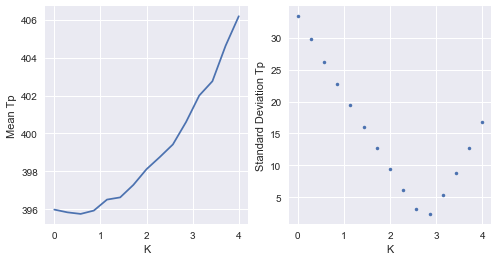

In [179]:
plt.figure(figsize=(8, 4))
plt.subplot('121')
plt.plot(Klst, meanlst)
plt.xlabel('K')
plt.ylabel('Mean Tp')

plt.subplot('122')
plt.plot(Klst, varlst, '.')
plt.xlabel('K')
plt.ylabel('Standard Deviation Tp')

In [8]:
ntrials = 100
nsteps = 5000
goal = 500
Kval = 3
state_dict = {'u': np.array([0.7] * ntrials), 'v': np.array([0.2] * ntrials)}
threshold = 0.1

# Module 1
ext_module1 = np.random.normal(loc=0, scale=0.3, size=ntrials)
param_dict_module = {'Wut': 6, 'Wvt': 6, 'Wuv': 6, 'Wvu': 6,
              'theta': 0.8, 'tau': 100, 'dt': 1, 'ext': ext_module1, 'sigma': 0.2}
_, final_pos1, times_lst1 = simulate_module(ntrials, nsteps, goal, ext_module1, 
                                            param_dict_module, K=Kval, ext_updating=False)
#times_lst1 = get_times_lst(state_dict, param_dict_module, nsteps, threshold)

# Module 2
ext_module2, final_pos2, times_lst2 = simulate_module(ntrials, nsteps, goal, ext_module1, 
                                                      param_dict_module, 
                                          K=Kval, prev_final=final_pos1, ext_updating=True)

# Module3
ext_module3, final_pos3, times_lst3 = simulate_module(ntrials, nsteps, goal, ext_module2, 
                                                      param_dict_module, 
                                          K=Kval, prev_final=final_pos2, ext_updating=True)

Bound not reached
Bound not reached
Bound not reached
Bound not reached
Bound not reached
Bound not reached
Bound not reached
Bound not reached
Bound not reached
Bound not reached
Bound not reached
Bound not reached
Bound not reached
Bound not reached


In [9]:
ntrials = 100
nsteps = 5000
goal = 1500
Kval = 3
state_dict = {'u': np.array([0.7] * ntrials), 'v': np.array([0.2] * ntrials)}
threshold = 0.1

# Module 1
ext_module1 = np.random.normal(loc=0, scale=0.3, size=ntrials)
param_dict_module = {'Wut': 6, 'Wvt': 6, 'Wuv': 6, 'Wvu': 6,
              'theta': 0.8, 'tau': 100, 'dt': 1, 'ext': ext_module1, 'sigma': 0.2}
_, final_pos_single, times_lst_single = simulate_module(ntrials, nsteps, goal, ext_module1, 
                                            param_dict_module, K=Kval, ext_updating=False)

Bound not reached
Bound not reached
Bound not reached
Bound not reached
Bound not reached
Bound not reached
Bound not reached
Bound not reached
Bound not reached
Bound not reached
Bound not reached
Bound not reached
Bound not reached
Bound not reached
Bound not reached
Bound not reached
Bound not reached
Bound not reached
Bound not reached
Bound not reached
Bound not reached
Bound not reached
Bound not reached
Bound not reached
Bound not reached
Bound not reached
Bound not reached
Bound not reached
Bound not reached
Bound not reached
Bound not reached
Bound not reached
Bound not reached
Bound not reached
Bound not reached
Bound not reached
Bound not reached
Bound not reached
Bound not reached
Bound not reached


In [139]:
def simulate_multiple_modules(ntrials, nsteps, total_duration, Kval, nmodules, sigma_mu, sigma_sigma):
    '''Simulate multiple modules in a cascade.
    ntrials: number of trials
    nsteps: number of time steps per trial
    total_duration: total time steps for N modules
    Kval: constant K for updating input
    nmodules: number of modules'''
    param_dict_module = {'Wut': 6, 'Wvt': 6, 'Wuv': 6, 'Wvu': 6,
              'theta': 0.8, 'tau': 100, 'dt': 1, 'ext': ext_module1, 'sigma': sigma_sigma}
    subgoal = int(total_duration / nmodules)
    
    # Initial input to module 1
    ext_module_init = np.random.normal(loc=0, scale=sigma_mu, size=ntrials)

    for i in range(nmodules):
        print('Simulating module', i)
        if i == 0:
            ext_module, final_pos, total_times = simulate_module(ntrials, nsteps, subgoal, ext_module_init, 
                                                      param_dict_module, 
                                          K=Kval, ext_updating=False)
        else:
            ext_module, final_pos, times_lst = simulate_module(ntrials, nsteps, subgoal, ext_module, 
                                                      param_dict_module, 
                                          K=Kval, prev_final=final_pos, ext_updating=True)
            total_times += times_lst
    return total_times

Simulating module 0
(1000,)
(1000,)
Simulating module 0
(1000,)
(1000,)
Simulating module 1
(1000,)
(1000,)
Simulating module 0
(1000,)
(1000,)
Simulating module 1
(1000,)
(1000,)
Simulating module 2
(1000,)
(1000,)
Simulating module 0
(1000,)
(1000,)
Simulating module 1
(1000,)
(1000,)
Simulating module 2
(1000,)
(1000,)
Simulating module 3
(1000,)
(1000,)
Simulating module 0
(1000,)
(1000,)
Simulating module 1
(1000,)
(1000,)
Simulating module 2
(1000,)
(1000,)
Simulating module 3
(1000,)
(1000,)
Simulating module 4
(1000,)
(1000,)
Simulating module 0
(1000,)
(1000,)
Simulating module 1
(1000,)
(1000,)
Simulating module 2
(1000,)
(1000,)
Simulating module 3
(1000,)
(1000,)
Simulating module 4
(1000,)
(1000,)
Simulating module 5
(1000,)
(1000,)
Simulating module 0
(1000,)
(1000,)
Simulating module 1
(1000,)
(1000,)
Simulating module 2
(1000,)
(1000,)
Simulating module 3
(1000,)
(1000,)
Simulating module 4
(1000,)
(1000,)
Simulating module 5
(1000,)
(1000,)
Simulating module 6
(1000,)


TypeError: Cannot cast ufunc add output from dtype('float64') to dtype('int64') with casting rule 'same_kind'

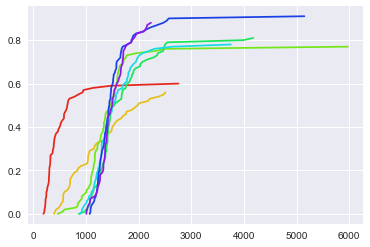

In [142]:
palette = sns.hls_palette(8, l=0.5, s=0.8)
#palette = sns.color_palette('hls', 10)
for i in range(1, 9):
    time_lst = simulate_multiple_modules(1000, 5000, 1500, 3, i, 0.5, 0.2)
    x, y = ecdf(time_lst)
    plt.plot(x, y, color=palette[i - 1], label=str(i))
plt.legend(title='N modules', ncol=2)
plt.xlabel('Time (steps)')
plt.ylabel('Cumulative Frequency')
#save_safe('cascade_performance.pdf')

In [43]:
ntrials = 100
nsteps = 5000
goal = 500
Kval = 3
state_dict = {'u': np.array([0.7] * ntrials), 'v': np.array([0.2] * ntrials)}
threshold = 0.1

# Module 1
ext_module1 = np.random.normal(loc=0, scale=0.3, size=ntrials)
param_dict_module = {'Wut': 6, 'Wvt': 6, 'Wuv': 6, 'Wvu': 6,
              'theta': 0.8, 'tau': 100, 'dt': 1, 'ext': ext_module1, 'sigma': 0.2}
_, final_pos1, times_lst1 = simulate_module(ntrials, nsteps, goal, ext_module1, 
                                            param_dict_module, K=Kval, ext_updating=False)
#times_lst1 = get_times_lst(state_dict, param_dict_module, nsteps, threshold)

# Module 2
ext_module2, final_pos2, times_lst2 = simulate_module(ntrials, nsteps, goal, ext_module1, 
                                                      param_dict_module, 
                                          K=Kval, prev_final=final_pos1, ext_updating=True)

# Module3
ext_module3, final_pos3, times_lst3 = simulate_module(ntrials, nsteps, goal, ext_module2, 
                                                      param_dict_module, 
                                          K=Kval, prev_final=final_pos2, ext_updating=True)

Bound not reached
Bound not reached
Bound not reached
Bound not reached
Bound not reached
Bound not reached
Bound not reached
Bound not reached
Bound not reached
Bound not reached
Bound not reached
Bound not reached
Bound not reached
Bound not reached
Bound not reached
Bound not reached
Bound not reached


In [47]:
times_lst1 + times_lst2 + times_lst3

array([ 1685.,  1682.,  1355.,  1544.,    inf,  2489.,  1795.,    inf,
        1312.,  3226.,  1494.,  1219.,    inf,  1348.,    inf,  1715.,
        1200.,  1013.,   834.,  1144.,  1364.,  1158.,  1094.,  1285.,
        2208.,    inf,    inf,    inf,  1254.,  1418.,    inf,  1484.,
        1288.,  1449.,  1670.,  1353.,  1415.,  1267.,    inf,  1512.,
        1335.,    inf,  2130.,  1258.,  1247.,  1550.,  1318.,  1123.,
        1434.,    inf,  1214.,  1623.,    inf,  1160.,  1367.,  1352.,
        1589.,  1465.,  2112.,    inf,    inf,  1016.,  1606.,  1474.,
        4944.,  1536.,  1695.,    inf,  1456.,  1624.,  1420.,  1223.,
          inf,  1100.,  1835.,  1789.,  1329.,  1413.,  2805.,  1438.,
         935.,  2023.,  1904.,  1112.,   989.,  1475.,  1292.,  1250.,
        1678.,  1742.,  1161.,  1252.,  1701.,  1203.,    inf,  1400.,
        1120.,  1294.,  1916.,  2135.])

In [10]:
ntrials = 100
nsteps = 5000
goal = 150
Kval = 3
state_dict = {'u': np.array([0.7] * ntrials), 'v': np.array([0.2] * ntrials)}
threshold = 0.1

# Module 1
ext_module1 = np.random.normal(loc=0, scale=0.3, size=ntrials)
param_dict_module = {'Wut': 6, 'Wvt': 6, 'Wuv': 6, 'Wvu': 6,
              'theta': 0.8, 'tau': 100, 'dt': 1, 'ext': ext_module1, 'sigma': 0.2}
_, final_pos1, times_lst1 = simulate_module(ntrials, nsteps, goal, ext_module1, 
                                            param_dict_module, K=Kval, ext_updating=False)
#times_lst1 = get_times_lst(state_dict, param_dict_module, nsteps, threshold)

# Module 2
ext_module2, final_pos2, times_lst2 = simulate_module(ntrials, nsteps, goal, ext_module1, 
                                                      param_dict_module, 
                                          K=Kval, prev_final=final_pos1, ext_updating=True)

# Module3
ext_module3, final_pos3, times_lst3 = simulate_module(ntrials, nsteps, goal, ext_module2, 
                                                      param_dict_module, 
                                          K=Kval, prev_final=final_pos2, ext_updating=True)
ext_module4, final_pos4, times_lst4 = simulate_module(ntrials, nsteps, goal, ext_module3, 
                                                      param_dict_module, 
                                          K=Kval, prev_final=final_pos3, ext_updating=True)
ext_module5, final_pos5, times_lst5 = simulate_module(ntrials, nsteps, goal, ext_module4, 
                                                      param_dict_module, 
                                          K=Kval, prev_final=final_pos4, ext_updating=True)
ext_module6, final_pos6, times_lst6 = simulate_module(ntrials, nsteps, goal, ext_module5, 
                                                      param_dict_module, 
                                          K=Kval, prev_final=final_pos5, ext_updating=True)
ext_module7, final_pos7, times_lst7 = simulate_module(ntrials, nsteps, goal, ext_module6, 
                                                      param_dict_module, 
                                          K=Kval, prev_final=final_pos6, ext_updating=True)
ext_module8, final_pos8, times_lst8 = simulate_module(ntrials, nsteps, goal, ext_module7, 
                                                      param_dict_module, 
                                          K=Kval, prev_final=final_pos7, ext_updating=True)
ext_module9, final_pos9, times_lst9 = simulate_module(ntrials, nsteps, goal, ext_module8, 
                                                      param_dict_module, 
                                          K=Kval, prev_final=final_pos8, ext_updating=True)
ext_module10, final_pos10, times_lst10 = simulate_module(ntrials, nsteps, goal, ext_module9, 
                                                      param_dict_module, 
                                          K=Kval, prev_final=final_pos9, ext_updating=True)

(array([ 0.00168919,  0.00084459,  0.00197072,  0.00253378,  0.00168919,
         0.00197072,  0.00112613,  0.00056306,  0.00028153,  0.00084459]),
 array([ 244.,  318.,  392.,  466.,  540.,  614.,  688.,  762.,  836.,
         910.,  984.]),
 <a list of 10 Patch objects>)

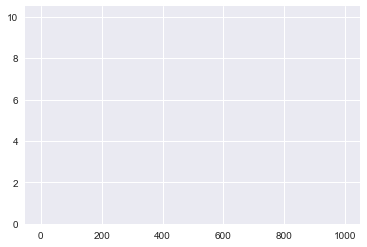

In [11]:
plt.hist(times_lst1[times_lst1 < 1000], normed=True, range=(0, 1000))
plt.hist(times_lst2[times_lst2 < 1000], normed=True)
plt.hist(times_lst3[times_lst3 < 1000], normed=True)
plt.hist(times_lst_single[times_lst_single < 1000], normed=True)
#plt.xlim(0, 1000)

In [13]:
# Module 1!
ntrials = 100
nsteps = 0
ext_module1 = np.random.normal(loc=0, scale=0.3, size=ntrials)
param_dict_module1 = {'Wut': 6, 'Wvt': 6, 'Wuv': 6, 'Wvu': 6,
              'theta': 0.8, 'tau': 100, 'dt': 1, 'ext': ext_module1, 'sigma': 0.1}

state_dict = {'u': np.array([0.7] * ntrials), 'v': np.array([0.2] * ntrials)}
ulst_noise1, vlst_noise1 = simulate_u_v_exp_multi(state_dict, param_dict_module1, 300)
final_pos1 = (ulst_noise1 - vlst_noise1)[-1, :]

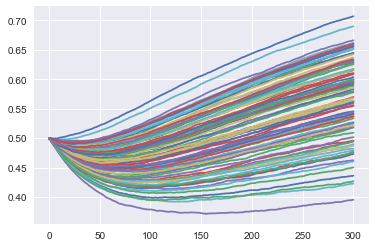

In [15]:
decision_v = ulst_noise1 - vlst_noise1
plt.plot(decision_v);

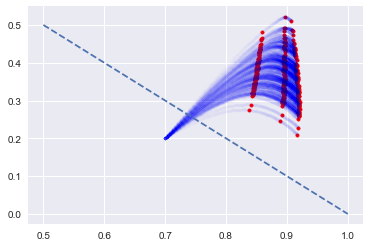

In [16]:
plt.plot(ulst_noise1, vlst_noise1, 'b.', alpha=0.01);
k = np.linspace(0.5, 1, 100)
plt.scatter(ulst_noise1[100,:], vlst_noise1[100,:], color='r', marker='.');
plt.scatter(ulst_noise1[200,:], vlst_noise1[200,:], color='r', marker='.');
plt.scatter(ulst_noise1[300,:], vlst_noise1[300,:], color='r', marker='.');
plt.plot(k , 1 - k, '--')

In [17]:
# Module 2!
ref2 = np.mean(final_pos1)
k2 = 2
ext_module2 = (ext_module1 + k2 * (final_pos1 - ref2))

param_dict_module2 = {'Wut': 6, 'Wvt': 6, 'Wuv': 6, 'Wvu': 6,
              'theta': 0.8, 'tau': 100, 'dt': 1, 'ext': ext_module2, 'sigma': 0}

state_dict = {'u': np.array([0.7] * ntrials), 'v': np.array([0.2] * ntrials)}
ulst_noise2, vlst_noise2 = simulate_u_v_exp_multi(state_dict, param_dict_module2, 300)
decision_v2 = ulst_noise2 - vlst_noise2
final_pos2 = (ulst_noise2 - vlst_noise2)[-1, :]

OSError: File exists!

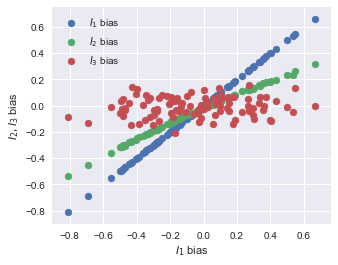

In [18]:
plt.figure(figsize=(5, 4))
plt.scatter(ext_module1, ext_module1, label=r'$I_1$ bias')
plt.scatter(ext_module1, ext_module2, label=r'$I_2$ bias')
plt.scatter(ext_module1, ext_module3, label=r'$I_3$ bias')
plt.xlabel(r'$I_1$ bias')
plt.ylabel(r'$I_2, I_3$ bias')
plt.legend()
save_safe('bias_three_modules_sigma_mu_K-4.pdf')

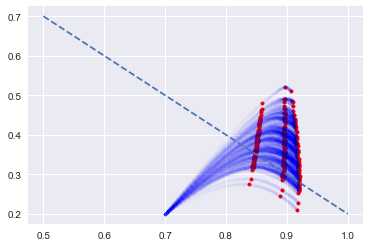

In [20]:
plt.plot(ulst_noise1, vlst_noise1, 'b.', alpha=0.01);
k = np.linspace(0.5, 1, 100)
plt.scatter(ulst_noise1[100,:], vlst_noise1[100,:], color='r', marker='.');
plt.scatter(ulst_noise1[200,:], vlst_noise1[200,:], color='r', marker='.');
plt.scatter(ulst_noise1[300,:], vlst_noise1[300,:], color='r', marker='.');
plt.plot(k , 1 - k + 0.2, '--')

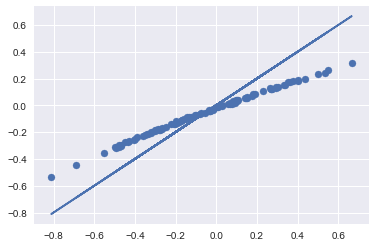

In [21]:
plt.scatter(ext_module1, ext_module2)
plt.plot(ext_module1, ext_module1)

In [22]:
# Module 2!
ref2 = np.mean(final_pos1)
k2 = 2
ext_module2 = (ext_module1 + k2 * (final_pos1 - ref2))

param_dict_module2 = {'Wut': 6, 'Wvt': 6, 'Wuv': 6, 'Wvu': 6,
              'theta': 0.8, 'tau': 100, 'dt': 1, 'ext': ext_module2, 'sigma': 0}

state_dict = {'u': np.array([0.7] * ntrials), 'v': np.array([0.2] * ntrials)}
ulst_noise2, vlst_noise2 = simulate_u_v_exp_multi(state_dict, param_dict_module2, 300)
decision_v2 = ulst_noise2 - vlst_noise2
final_pos2 = (ulst_noise2 - vlst_noise2)[-1, :]


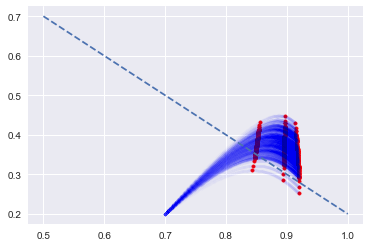

In [23]:
plt.plot(ulst_noise2, vlst_noise2, 'b.', alpha=0.01);
k = np.linspace(0.5, 1, 100)
plt.scatter(ulst_noise2[100,:], vlst_noise2[100,:], color='r', marker='.');
plt.scatter(ulst_noise2[200,:], vlst_noise2[200,:], color='r', marker='.');
plt.scatter(ulst_noise2[300,:], vlst_noise2[300,:], color='r', marker='.');

plt.plot(k , 1 - k + 0.2, '--')

OSError: File exists!

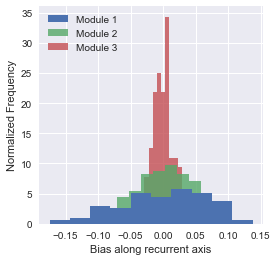

In [24]:
plt.figure(figsize=(4, 4))
plt.hist(final_pos1 - np.mean(final_pos1), normed=True, alpha=1, label='Module 1', zorder=5)
plt.hist(final_pos2 - np.mean(final_pos2), normed=True, alpha=0.8, label='Module 2', zorder=4)
plt.hist(final_pos3 - np.mean(final_pos3), normed=True, alpha=0.8, label='Module 3', zorder=3)
plt.xlabel('Bias along recurrent axis')
plt.ylabel('Normalized Frequency')
plt.legend(loc='upper left')
save_safe('bias_three_modules.pdf')

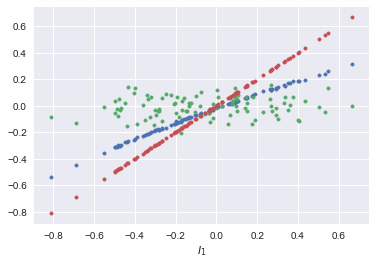

In [25]:
plt.scatter(ext_module1, ext_module2, marker='.')
plt.scatter(ext_module1, ext_module3, marker='.')
plt.scatter(ext_module1, ext_module1, marker='.')
plt.xlabel(r'$I_1$')

In [26]:
# Module 3!
ref3 = np.mean(final_pos2)
k3 = 2
ext_module3 = (ext_module2 + k3 * (final_pos2 - ref3))

param_dict_module3 = {'Wut': 6, 'Wvt': 6, 'Wuv': 6, 'Wvu': 6,
              'theta': 0.8, 'tau': 100, 'dt': 1, 'ext': ext_module3, 'sigma': 0}

state_dict = {'u': np.array([0.7] * ntrials), 'v': np.array([0.2] * ntrials)}
ulst_noise3, vlst_noise3 = simulate_u_v_exp_multi(state_dict, param_dict_module3, 400)
final_pos3 = (ulst_noise3 - vlst_noise3)[-1, :]
action_times = get_times_lst(state_dict, param_dict_module3, 1000, thresh)



NameError: name 'thresh' is not defined

Bound not reached
Bound not reached
Bound not reached
Bound not reached
Bound not reached
Bound not reached
Bound not reached
Bound not reached
Bound not reached
Bound not reached
Bound not reached
Bound not reached
Bound not reached
Bound not reached
Bound not reached
Bound not reached
Bound not reached
Bound not reached
Bound not reached
Bound not reached
Bound not reached
Bound not reached
Bound not reached
Bound not reached
Bound not reached
Bound not reached
Bound not reached
Bound not reached
Bound not reached
Bound not reached
Bound not reached
Bound not reached
Bound not reached
Bound not reached
Bound not reached
Bound not reached
Bound not reached
Bound not reached
Bound not reached
Bound not reached
Bound not reached
Bound not reached
Bound not reached
Bound not reached
Bound not reached
Bound not reached
Bound not reached
Bound not reached
Bound not reached
Bound not reached
Bound not reached
Bound not reached
Bound not reached
Bound not reached
Bound not reached
Bound not 

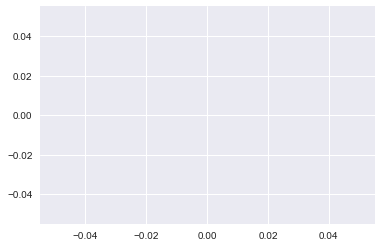

In [27]:
# Module 4 (readout)
ref4 = 1
k4 = 5
thresh = 0.8
ext_module4 = (ext_module3 - k4 * (final_pos3 - ref4))
param_dict_module4 = {'Wut': 6, 'Wvt': 6, 'Wuv': 6, 'Wvu': 6,
              'theta': 0.5, 'tau': 100, 'dt': 1, 'ext': ext_module4, 'sigma': 0}


action_times = get_times_lst(state_dict, param_dict_module4, 1000, thresh)
x, y = ecdf(action_times)
plt.plot(x, y)

Bound not reached
Bound not reached
Bound not reached
Bound not reached
Bound not reached
Bound not reached
Bound not reached
Bound not reached
Bound not reached
Bound not reached
Bound not reached
Bound not reached
Bound not reached
Bound not reached
Bound not reached
Bound not reached
Bound not reached
Bound not reached
Bound not reached
Bound not reached
Bound not reached
Bound not reached
Bound not reached
Bound not reached
Bound not reached
Bound not reached
Bound not reached
Bound not reached
Bound not reached
Bound not reached
Bound not reached
Bound not reached
Bound not reached
Bound not reached
Bound not reached
Bound not reached
Bound not reached
Bound not reached
Bound not reached
Bound not reached
Bound not reached
Bound not reached
Bound not reached
Bound not reached
Bound not reached
Bound not reached
Bound not reached
Bound not reached
Bound not reached
Bound not reached
Bound not reached
Bound not reached
Bound not reached
Bound not reached
Bound not reached
Bound not 

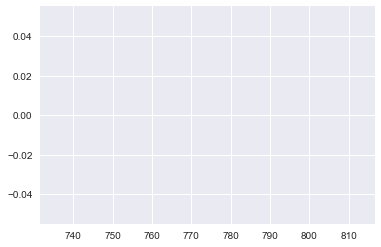

In [28]:
# Compare to a single module
action_times2 = get_times_lst(state_dict, param_dict_module1, 1000, thresh)
action_times = get_times_lst(state_dict, param_dict_module4, 1000, thresh)

x1, y1 = ecdf(action_times)
x2, y2 = ecdf(action_times2)
plt.plot(x1, y1)
plt.plot(x2, y2)

## Effect of $\sigma_\sigma$

In [29]:
# Module 1!
ntrials = 100
nsteps = 400
#ext_module1 = np.random.normal(loc=0, scale=0.1, size=ntrials)
param_dict_noise = {'Wut': 6, 'Wvt': 6, 'Wuv': 6, 'Wvu': 6,
              'theta': 0.5, 'tau': 100, 'dt': 1, 'ext': 0, 'sigma': 0.6}
param_dict_no_noise = {'Wut': 6, 'Wvt': 6, 'Wuv': 6, 'Wvu': 6,
              'theta': 0.5, 'tau': 100, 'dt': 1, 'ext': 0, 'sigma': 0}

state_dict = {'u': np.array([0.7] * ntrials), 'v': np.array([0.2] * ntrials)}
ulst_noise1, vlst_noise1 = simulate_u_v_exp_multi(state_dict, param_dict_noise, nsteps)
ulst_no_noise, vlst_no_noise = simulate_u_v_exp_multi(state_dict, param_dict_no_noise, nsteps)

decision_v = ulst_noise1 - vlst_noise1
final_pos = decision_v[-1]
ref_decision = np.mean(final_pos)

ext_lst = ref_decision - final_pos

In [30]:
# Module 2!
param_dict_noise['ext'] = ext_lst * 10
ulst_noise2, vlst_noise2 = simulate_u_v_exp_multi(state_dict, param_dict_noise, nsteps)

decision_v2 = ulst_noise2 - vlst_noise2
final_pos2 = decision_v2[-1]
ref_decision2 = np.mean(final_pos2)

ext_lst2 = ref_decision2 - final_pos2


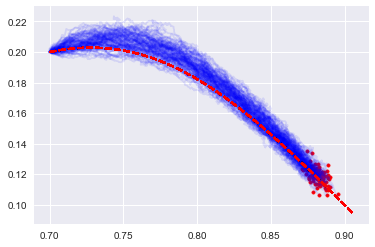

In [31]:
plt.plot(ulst_noise1, vlst_noise1, 'b', alpha=0.1);
plt.plot(ulst_no_noise, vlst_no_noise, 'r--');
plt.scatter(ulst_noise1[-1], vlst_noise1[-1], color='r', marker='.')

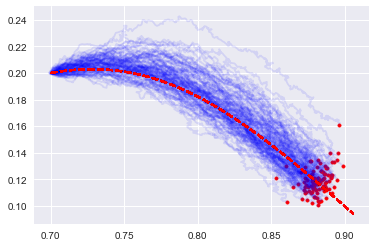

In [32]:
plt.plot(ulst_noise2, vlst_noise2, 'b', alpha=0.1);
plt.plot(ulst_no_noise, vlst_no_noise, 'r--');
plt.scatter(ulst_noise2[-1], vlst_noise2[-1], color='r', marker='.')